In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jessicali9530_celeba_dataset_path = kagglehub.dataset_download('jessicali9530/celeba-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'celeba-dataset' dataset.
Data source import complete.


In [ ]:
import os

dataroot = os.path.join(
    jessicali9530_celeba_dataset_path,
    "img_align_celeba"
)

print("Using data from:", dataroot)


Using data from: /kaggle/input/celeba-dataset/img_align_celeba


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
  # pass
  # print(dirname)
  # for filename in filenames:
      # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/celeba-dataset
/kaggle/input/celeba-dataset/img_align_celeba
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba


In [ ]:
%matplotlib inline

In [ ]:
#%matplotlib inline
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [ ]:
# Root directory for dataset

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
#image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details. - https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#:~:text=image_size%20%2D%20the%20spatial%20size%20of%20the%20images%20used%20for%20training.%20This%20implementation%20defaults%20to%2064x64.%20If%20another%20size%20is%20desired%2C%20the%20structures%20of%20D%20and%20G%20must%20be%20changed.%20See%20here%20for%20more%20details.



In [ ]:
from torchvision.transforms import v2
img_transform = v2.Compose([
    v2.Resize(size = (64,64), antialias = True),
    v2.CenterCrop(64),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

In [ ]:
from torchvision import datasets

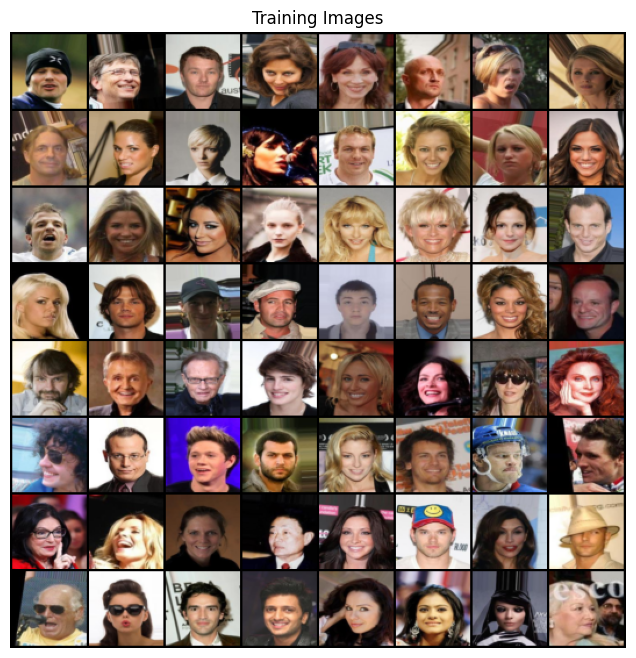

In [ ]:
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(
    root=dataroot,
    transform = img_transform
)



# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)



# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
img_batch , label_batch = next(iter(dataloader))
img_batch.size(0), label_batch.shape,label_batch

(128,
 torch.Size([128]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

Though `ImageFolder` by default iniitalized all img label as 0, we will use our custom label. All img here in datset/dataloader i real so label of all of them is 1, and generated img using `rand` will be labeled as 0

### weight initialization

From the DCGAN paper, the authors specify that `all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.` The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [ ]:
# custom weight for our two model : generator and descriminator

from torch import nn

def weight_init(m : torch.nn.Module):
  class_name = m.__class__.__name__
  if class_name.find('Conv') != -1:
    nn.init.normal_(m.weight.data , 0.0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data , 1.0 , 0.02)
    nn.init.constant_(m.bias.data , 0)

## Generator

As our img shape is `3x64x64`(after transform), the output shape of our generator will be also : `batch_size x 3 x 64 x 64`

the `out_channel | hidden unit` will be 100(ngf).

The generator takes input of shape `batch_size x 100 x 1 x 1` . The input will be generated complety from random tensor with normal distribution using `torch.randn`

And output shape will be same as our img shape : `batch_size x 3 x 64 x 64`

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super().__init__()
    self.ngpu = ngpu

    self.main = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels = nz, #nz = 100
            out_channels = ngf * 8, #ngf = 64
            kernel_size = 4,
            stride = 1,
            padding = 0,
            bias = False #by default: True
        ),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(
            in_channels = ngf * 8, #ngf = 64
            out_channels = ngf * 4, #ngf = 64
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False #by default: True
        ),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(
            in_channels = ngf * 4, #ngf = 64
            out_channels = ngf * 2, #ngf = 64
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False #by default: True
        ),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(
            in_channels = ngf * 2, #ngf = 64
            out_channels = ngf, #ngf = 64
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False #by default: True
        ),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        nn.ConvTranspose2d(
            in_channels = ngf , #ngf = 64
            out_channels = nc, # nc = 3
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False #by default: True
        ),
        nn.Tanh()
    )

  def forward(self, x):
    return self.main(x)

In [ ]:
#creating instance
netG = Generator(ngpu)
netG.to(device)

netG.apply(weight_init)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

##Discriminator

The discriminator discriminates  between real and fake(generated from generator) img

we first feed it real img and copute loss saying it was real img and then update the weights according

Again we feed false img and compute loos saying it was fake img and then update the weights accdording

Thus way, over time, discriminator improve itself distinguish between real and fake img

---

The discriminator takes img. so the input shape : `batch_size x 3 x 64 x 64` and outputs `0` or `1` for each img saying `0 - fake img` and `1 - real img`

the output shape generated from our discrimanator is : `batch_size x 1 x 1 x 1` with all val between 0 and 1 (as sigmoid used)

In [ ]:
class Discrinator(nn.Module):
  def __init__(self, ngpu):
    super().__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.Conv2d(
           in_channels = nc, #nc = 3
           out_channels = ndf, #ndf = 64
           kernel_size = 4,
           stride = 2,
           padding = 1,
           bias = False
        ),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),


        nn.Conv2d(
           in_channels = ndf, #ndf = 64
           out_channels = ndf * 2, #ndf = 64
           kernel_size = 4,
           stride = 2,
           padding = 1,
           bias = False
        ),
        nn.BatchNorm2d(ndf * 2), #ndf = 64
        nn.LeakyReLU(negative_slope=0.2, inplace = True),

        nn.Conv2d(
           in_channels = ndf * 2, #ndf = 64
           out_channels = ndf * 4, #ndf = 64
           kernel_size = 4,
           stride = 2,
           padding = 1,
           bias = False
        ),
        nn.BatchNorm2d(ndf * 4), #ndf = 64
        nn.LeakyReLU(negative_slope=0.2, inplace = True),


        nn.Conv2d(
           in_channels = ndf * 4, #ndf = 64
           out_channels = ndf * 8, #ndf = 64
           kernel_size = 4,
           stride = 2,
           padding = 1,
           bias = False
        ),
        nn.BatchNorm2d(ndf * 8), #ndf = 64
        nn.LeakyReLU(negative_slope=0.2, inplace = True),


        nn.Conv2d(
           in_channels = ndf * 8, #ndf = 64
           out_channels = 1, #ndf = 64
           kernel_size = 4,
           stride = 1,
           padding = 0,
           bias = False
        ),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)

In [ ]:
#initializing
netD = Discrinator(ngpu)
netD.to(device)

netD.apply(weight_init)

netD

Discrinator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## loss function and optimizer

In [ ]:
loss_fn = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(params=netD.parameters() , lr = lr, betas=(beta1, 0.999))

optimizerG = torch.optim.Adam(params=netG.parameters() , lr = lr , betas=(beta1, 0.999))

In [ ]:
#creating a fixed noise(random val). this will be feeded to generator to generate img from it
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_noise.shape

torch.Size([64, 100, 1, 1])

---
here is some code output that will be used in training loop
--

In [ ]:
batch_num = img_batch.size(0) #gives and int

img_batch.shape, batch_num, img_batch.shape[:1]

(torch.Size([128, 3, 64, 64]), 128, torch.Size([128]))

In [ ]:
lbl = torch.full(size =(batch_num,) ,fill_value = real_label , dtype=torch.float, device = device)
lbl , lbl.shape

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.], device='cuda:0'),
 torch.Size([128]))

In [ ]:
lbl.fill_(0.2) #it just fill the lbl with new val given in it


tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 

In [ ]:
out = netD(torch.randn(size = (128, 3, 64,64), dtype = torch.float32).to(device))
out.shape , out.reshape(-1).shape , out.flatten().shape, out.view(-1).shape

(torch.Size([128, 1, 1, 1]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]))

In [ ]:
out.flatten()

tensor([0.7292, 0.8530, 0.3893, 0.9712, 0.4993, 0.9641, 0.8777, 0.9537, 0.9770,
        0.6034, 0.4602, 0.4728, 0.7081, 0.8454, 0.8570, 0.9284, 0.8652, 0.2909,
        0.7136, 0.6526, 0.8203, 0.8569, 0.8466, 0.5960, 0.9637, 0.1541, 0.6720,
        0.6598, 0.5820, 0.8993, 0.4843, 0.9729, 0.9213, 0.8894, 0.8398, 0.7800,
        0.9713, 0.9029, 0.9469, 0.4074, 0.5381, 0.6948, 0.7659, 0.7434, 0.9368,
        0.9316, 0.7975, 0.8197, 0.9388, 0.9509, 0.7052, 0.5056, 0.7700, 0.7484,
        0.7762, 0.7871, 0.6560, 0.9813, 0.7929, 0.8588, 0.7446, 0.7109, 0.9482,
        0.5698, 0.7883, 0.8174, 0.8385, 0.6197, 0.9280, 0.8346, 0.9452, 0.7911,
        0.6668, 0.9302, 0.3845, 0.9052, 0.9010, 0.7132, 0.7583, 0.8800, 0.9161,
        0.8585, 0.8773, 0.9424, 0.6582, 0.9387, 0.4045, 0.8061, 0.8670, 0.8389,
        0.8692, 0.7623, 0.8088, 0.8822, 0.9000, 0.6595, 0.9296, 0.7116, 0.7992,
        0.6785, 0.7963, 0.8254, 0.8075, 0.8364, 0.7504, 0.7517, 0.9858, 0.4275,
        0.7393, 0.8615, 0.8602, 0.5861, 

In [ ]:
outG = netG(torch.randn(size = (124,100,1,1), dtype = torch.float32).to(device))
outG.shape

torch.Size([124, 3, 64, 64])

In [ ]:
len(dataloader)

1583

## Training loop

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as Timer

start_time = Timer()

img_list = []
D_losses = []
G_losses = []
counter = 0


for epoch in tqdm(range(num_epochs)): #num_epochs - 5
  for i, data in enumerate(dataloader):

    img_batch , _ = data

  #first: working on updating D
    netD.zero_grad()

    #train with real img

    img_batch = img_batch.to(device)
    batch_num = img_batch.size(0) #to get the first num in shape

    labels = torch.full(
        size = (batch_num,),
        fill_value = real_label, # 1
        dtype = torch.float32,
        device = device
    )
    output = netD(img_batch).flatten() #make higher dim to 1d

    errD_real = loss_fn(output, labels)

    errD_real.backward()

    D_x = output.mean().item()

    #train with fake img

    noise = torch.randn(size = (batch_num, nz, 1,1), device=device) #noise.shape -> 128 , 100, 1, 1
    fake_output = netG(noise) #fake shape -> 128, 3 , 64,64

    labels.fill_(fake_label)

    output = netD(fake_output.detach()).flatten()

    errD_fake = loss_fn(output , labels)

    errD_fake.backward()

    errD = errD_real + errD_fake

    optimizerD.step()

  #second: working on updating G

    netG.zero_grad()

    output = netD(fake_output).view(-1) # no detach -> Because now we want the gradient to reach G.
    #If we did fake_output.detach() here, it would cut off the path — G couldn’t learn how D judged its fakes.

    labels.fill_(real_label)
    errG = loss_fn(output, labels)
    errG.backward()
    optimizerG.step()

    #storing the losses to see how they are updating
    D_losses.append(errD.item())
    G_losses.append(errG.item())

    if i % 50 == 0:
      print(f"[{epoch}/{num_epochs}] | [{i}/{len(dataloader)}] | Loss_G : {errG} | Loss_D : {errD}")


    if counter % 500 == 0:
      with torch.inference_mode():
        fake_img_batch = netG(fixed_noise).detach().to('cpu') #shape : 64,3,64,64
        img_list.append(make_grid(fake_img_batch, padding=2 , normalize = True))

    counter += 1



end_time = Timer()

print(f'Total time taken : {(end_time - start_time) / 60 } min')

  0%|          | 0/5 [00:00<?, ?it/s]

[0/5] | [0/1583] | Loss_G : 2.797860622406006 | Loss_D : 0.6476866006851196
[0/5] | [50/1583] | Loss_G : 4.925265312194824 | Loss_D : 2.681596517562866
[0/5] | [100/1583] | Loss_G : 2.015394449234009 | Loss_D : 0.5593911409378052
[0/5] | [150/1583] | Loss_G : 2.540367841720581 | Loss_D : 0.5263828039169312
[0/5] | [200/1583] | Loss_G : 2.9849448204040527 | Loss_D : 0.6320460438728333
[0/5] | [250/1583] | Loss_G : 1.4657783508300781 | Loss_D : 0.8242467045783997
[0/5] | [300/1583] | Loss_G : 2.895777702331543 | Loss_D : 0.5199222564697266
[0/5] | [350/1583] | Loss_G : 2.9263534545898438 | Loss_D : 0.5378195643424988
[0/5] | [400/1583] | Loss_G : 1.0996818542480469 | Loss_D : 1.171351671218872
[0/5] | [450/1583] | Loss_G : 1.0276439189910889 | Loss_D : 0.7088606953620911
[0/5] | [500/1583] | Loss_G : 4.04707145690918 | Loss_D : 0.7982722520828247
[0/5] | [550/1583] | Loss_G : 0.3359419107437134 | Loss_D : 2.672328472137451
[0/5] | [600/1583] | Loss_G : 2.042337656021118 | Loss_D : 0.5080

### Think of it like this:

| Phase   | What you want to learn      | Should gradient reach G? | Should gradient reach D? | Use `.detach()`? |
| ------- | --------------------------- | ------------------------ | ------------------------ | ---------------- |
| Train D | Real vs Fake classification | ❌ No                     | ✅ Yes                    | ✅ Yes            |
| Train G | How to fool D               | ✅ Yes                    | ✅ (as pathway only)      | ❌ No             |


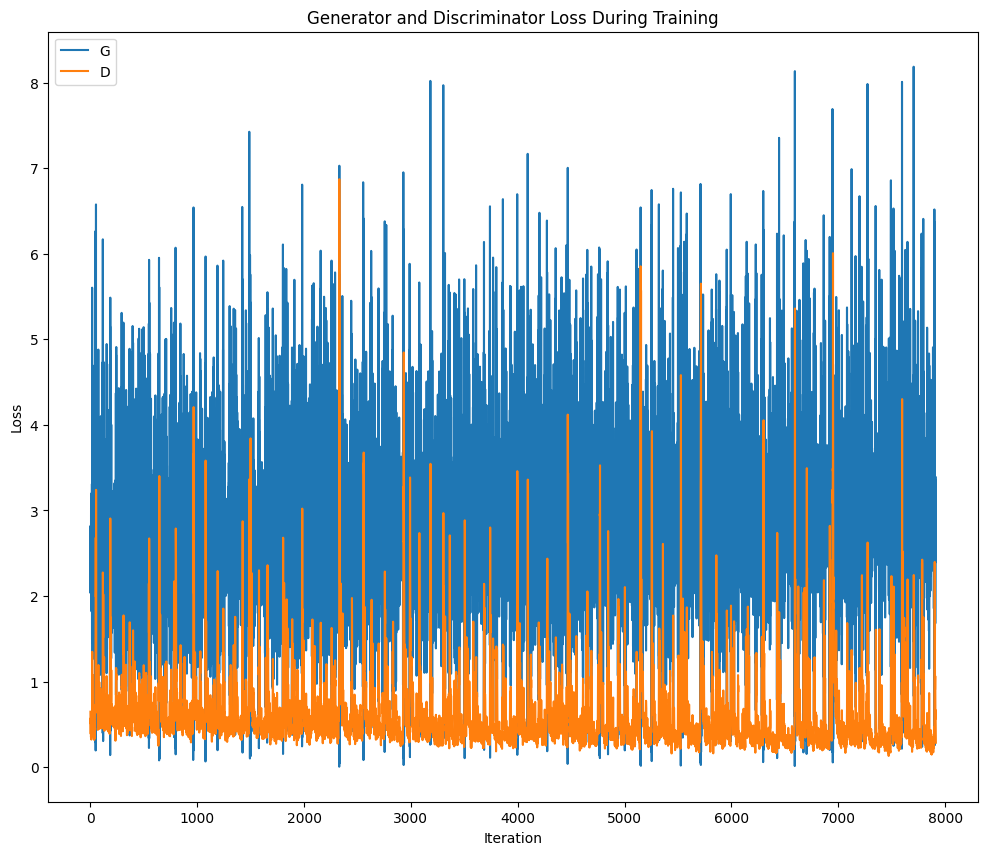

In [ ]:
##plot the losses
plt.figure(figsize=(12,10))
plt.plot(G_losses, label = "G")
plt.plot(D_losses , label = "D")


plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss During Training')

plt.legend()
plt.show()

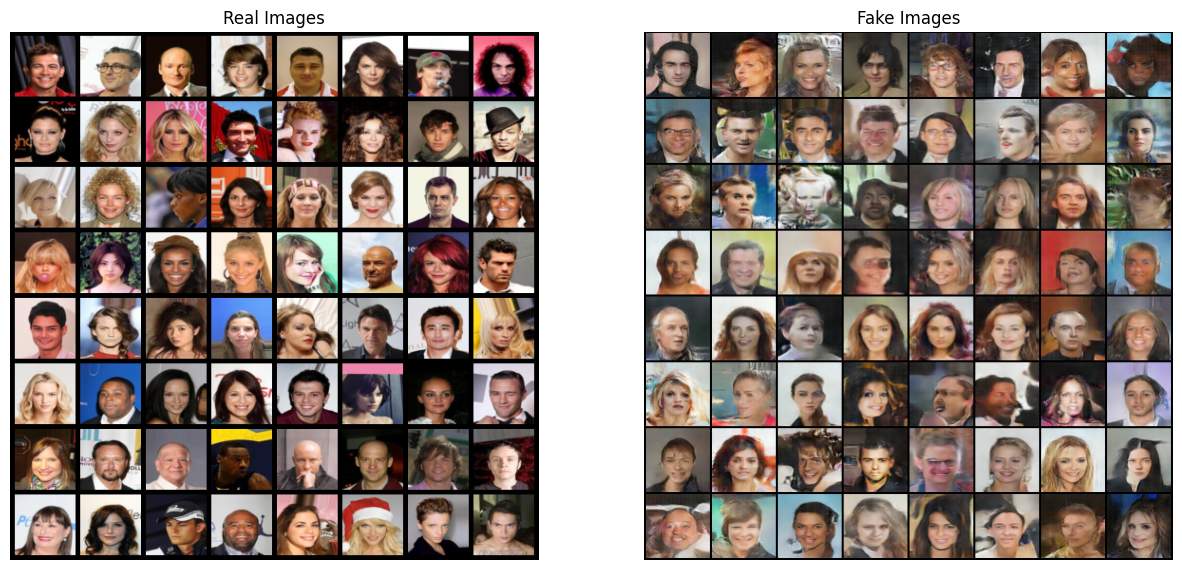

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()